# About  the data
PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

# Data Dictionary
1. Datetime: Timestamp column for every hour
2. PJMW_MW: estimated energy consumption in Megawatts (MW)



# Content
1. Trend across hour, date, day, weekday, weekend, month, year 
2. Distribution of energy consumption across time periods and seasons
3. Outliers and Missing values
4. Autocorrelation and Partial correlation
5. Decomposition
6. Rolling Statistics
7. Checking for seasonality, stationary
8. Forecast vs Actuals with prophet and XGBoost model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import missingno as msno
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from xgboost import XGBRegressor 
from prophet import Prophet
warnings.filterwarnings("ignore")

d:\ACADEMIC\ML Projects\Power Consumption Forecasting\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [7]:
power_forecasting=pd.read_csv('PJMW_hourly.csv')
power_forecasting.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


In [4]:
power_forecasting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143206 entries, 0 to 143205
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  143206 non-null  object 
 1   PJMW_MW   143206 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [6]:
power_forecasting['Datetime'] = pd.to_datetime(power_forecasting['Datetime'], format='%Y-%m-%d %H:%M:%S')
power_forecasting['Datetime'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 143206 entries, 0 to 143205
Series name: Datetime
Non-Null Count   Dtype         
--------------   -----         
143206 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.1 MB


In [4]:


def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    

power_forecasting['date']=power_forecasting['Datetime'].dt.date
power_forecasting['day']=power_forecasting['Datetime'].dt.day 
power_forecasting['month']=power_forecasting['Datetime'].dt.month
power_forecasting['year']=power_forecasting['Datetime'].dt.year 
power_forecasting['hour']=power_forecasting['Datetime'].dt.hour
power_forecasting['weekday_name']=power_forecasting['Datetime'].dt.day_name()
power_forecasting['season'] = power_forecasting['month'].apply(get_season)
power_forecasting['quarter'] = power_forecasting['Datetime'].dt.quarter
power_forecasting['week_of_year'] = power_forecasting['Datetime'].dt.isocalendar().week
power_forecasting['day_of_year'] = power_forecasting['Datetime'].dt.dayofyear
power_forecasting['week_type']=power_forecasting['Datetime'].dt.weekday.apply(lambda x:'Weekend' if x>=5 else 'Weekday')
power_forecasting.head()

,Datetime,PJMW_MW,date,day,month,year,hour,weekday_name,season,quarter,week_of_year,day_of_year,week_type
0,2002-12-31 01:00:00,5077.0,2002-12-31,31,12,2002,1,Tuesday,Winter,4,1,365,Weekday
1,2002-12-31 02:00:00,4939.0,2002-12-31,31,12,2002,2,Tuesday,Winter,4,1,365,Weekday
2,2002-12-31 03:00:00,4885.0,2002-12-31,31,12,2002,3,Tuesday,Winter,4,1,365,Weekday
3,2002-12-31 04:00:00,4857.0,2002-12-31,31,12,2002,4,Tuesday,Winter,4,1,365,Weekday
4,2002-12-31 05:00:00,4930.0,2002-12-31,31,12,2002,5,Tuesday,Winter,4,1,365,Weekday


### 1. Trend across hour, date, day, weekday, weekend, month, year

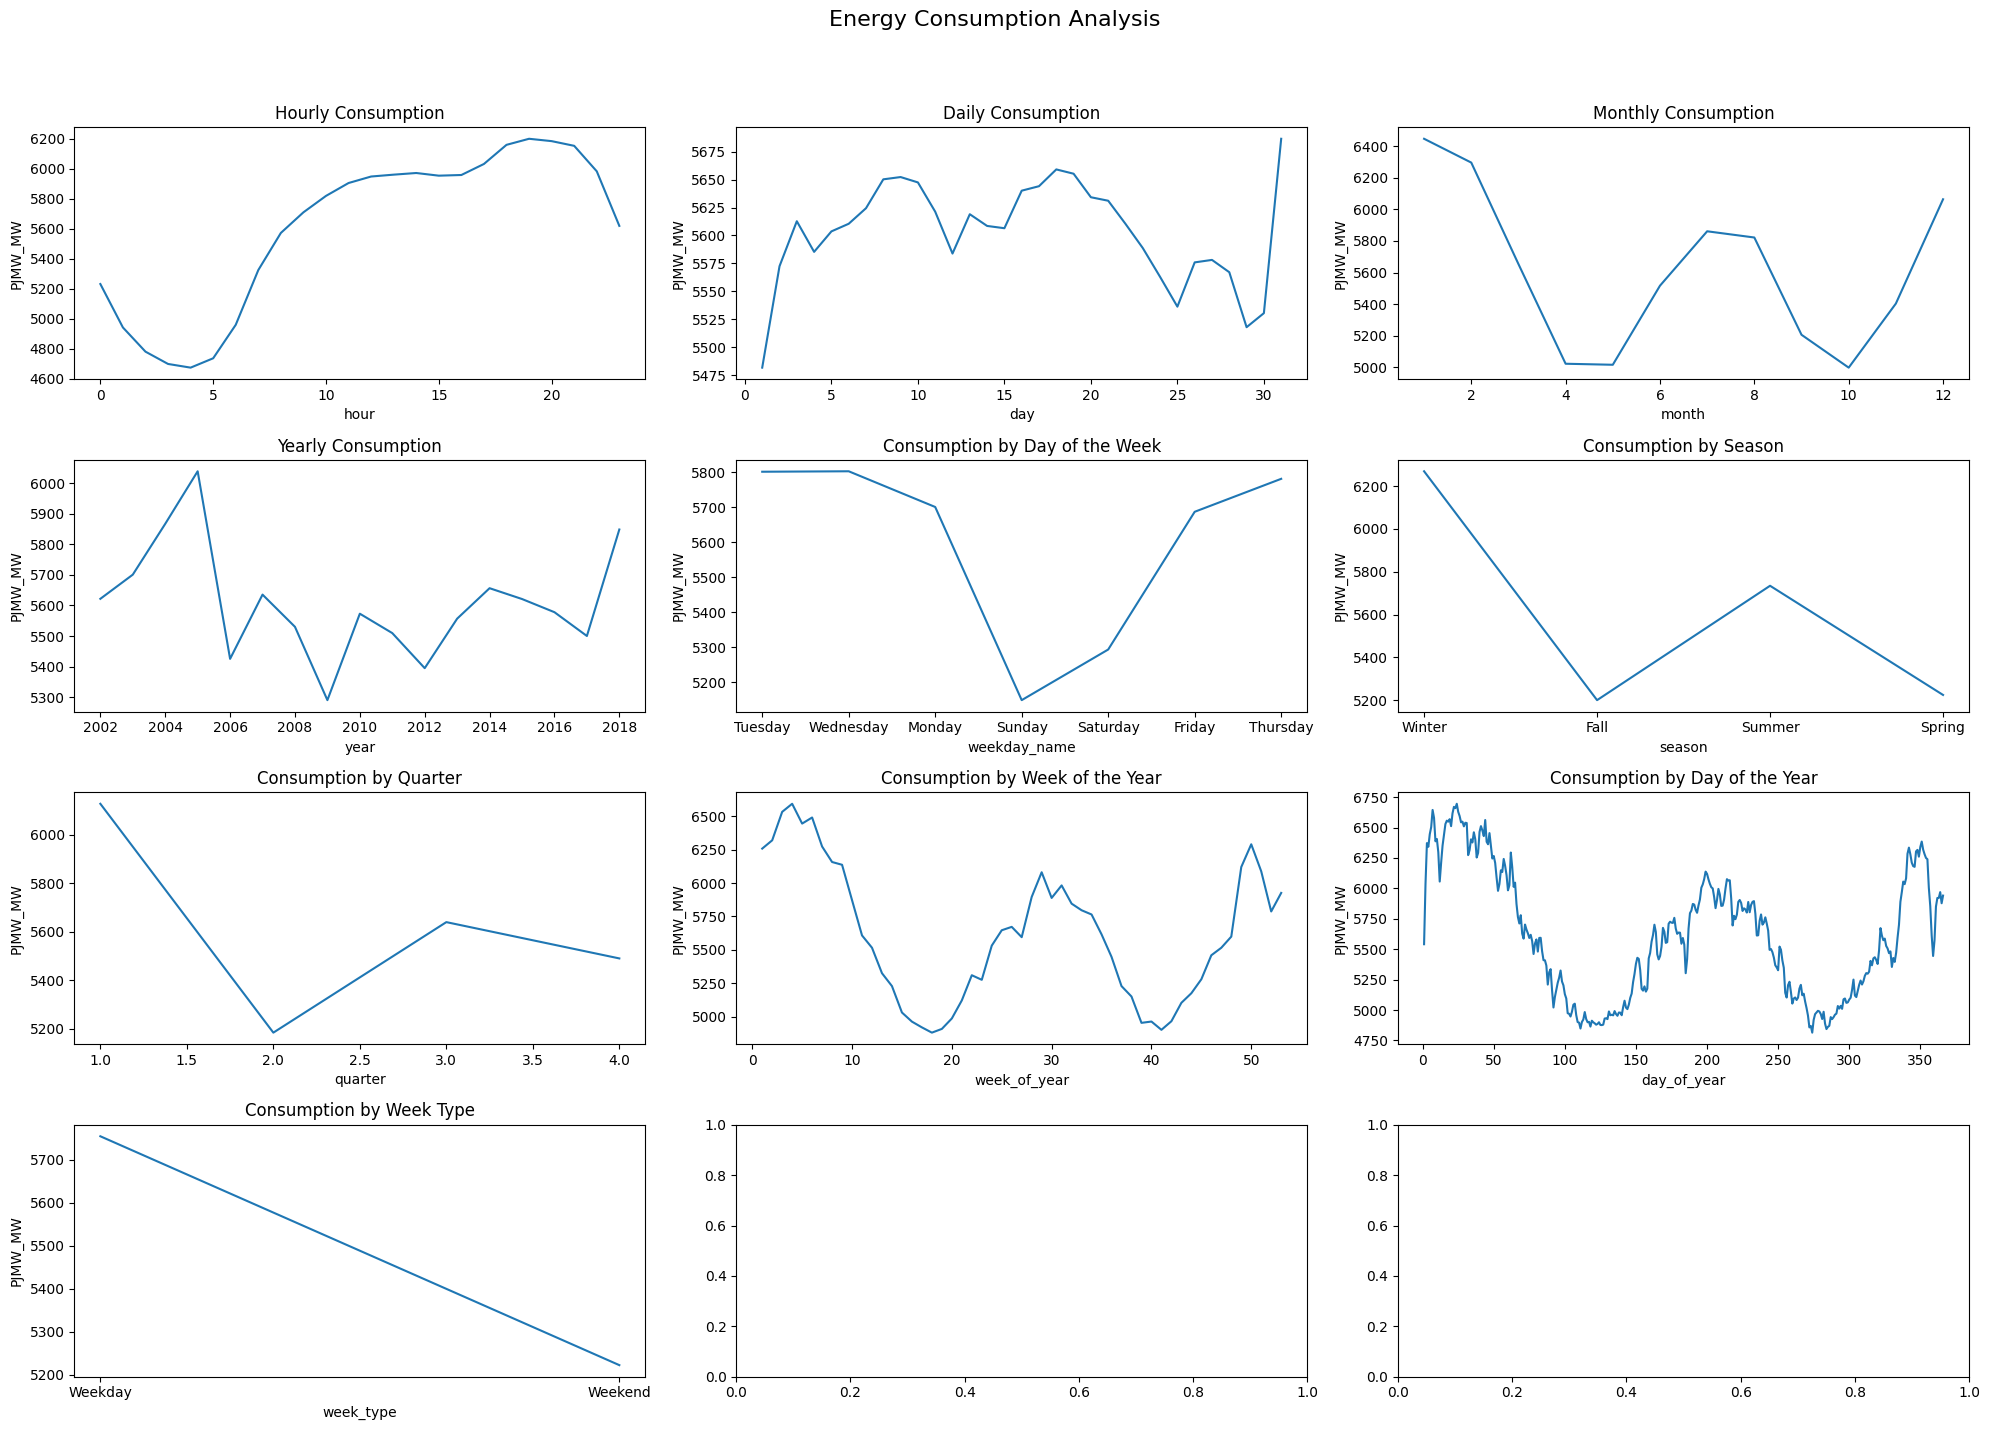

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
fig.suptitle('Energy Consumption Analysis', fontsize=16)

sns.lineplot(ax=axes[0, 0], data=power_forecasting, x='hour', y='PJMW_MW', ci=None)
axes[0, 0].set_title('Hourly Consumption')


sns.lineplot(ax=axes[0, 1], data=power_forecasting, x='day', y='PJMW_MW', ci=None)
axes[0, 1].set_title('Daily Consumption')


sns.lineplot(ax=axes[0, 2], data=power_forecasting, x='month', y='PJMW_MW', ci=None)
axes[0, 2].set_title('Monthly Consumption')


sns.lineplot(ax=axes[1, 0], data=power_forecasting, x='year', y='PJMW_MW', ci=None)
axes[1, 0].set_title('Yearly Consumption')


sns.lineplot(ax=axes[1, 1], data=power_forecasting, x='weekday_name', y='PJMW_MW', ci=None)
axes[1, 1].set_title('Consumption by Day of the Week')


sns.lineplot(ax=axes[1, 2], data=power_forecasting, x='season', y='PJMW_MW', ci=None)
axes[1, 2].set_title('Consumption by Season')


sns.lineplot(ax=axes[2, 0], data=power_forecasting, x='quarter', y='PJMW_MW', ci=None)
axes[2, 0].set_title('Consumption by Quarter')


sns.lineplot(ax=axes[2, 1], data=power_forecasting, x='week_of_year', y='PJMW_MW', ci=None)
axes[2, 1].set_title('Consumption by Week of the Year')


sns.lineplot(ax=axes[2, 2], data=power_forecasting, x='day_of_year', y='PJMW_MW', ci=None)
axes[2, 2].set_title('Consumption by Day of the Year')


sns.lineplot(ax=axes[3, 0], data=power_forecasting, x='week_type', y='PJMW_MW', ci=None)
axes[3, 0].set_title('Consumption by Week Type')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Insights
- Energy consumption is lowest around 3 AM and increases steadily, peaking around 6 PM . After 6 PM, consumption gradually decreases. Energy consumption increases during the day, peaking in the evening
- There is variability in daily consumption, with notable peaks around the end of the month, particularly on the 31st.  Outlier?
- Consumption is highest in January and December, with a significant dip in July. End of the month and year-end months see higher consumption.
- Energy consumption shows fluctuations over the years, with notable peaks in 2004, 2008, and 2018.
- The lowest consumption is on Sundays, and it increases significantly towards Fridays and Thursdays.
- Consumption is highest in winter and lowest in summer.
- The highest consumption is in the first quarter with significant drops in the subsequent quarters, reaching a low in the third quarter
- There are multiple peaks and troughs, with notable peaks around weeks 5, 20, and 50
- There is a fluctuating pattern throughout the year, with peaks around day 100 and day 350
-Weekday consumption is consistently higher compared to weekends 

### 2. Distribution of energy consumption across time periods and seasons

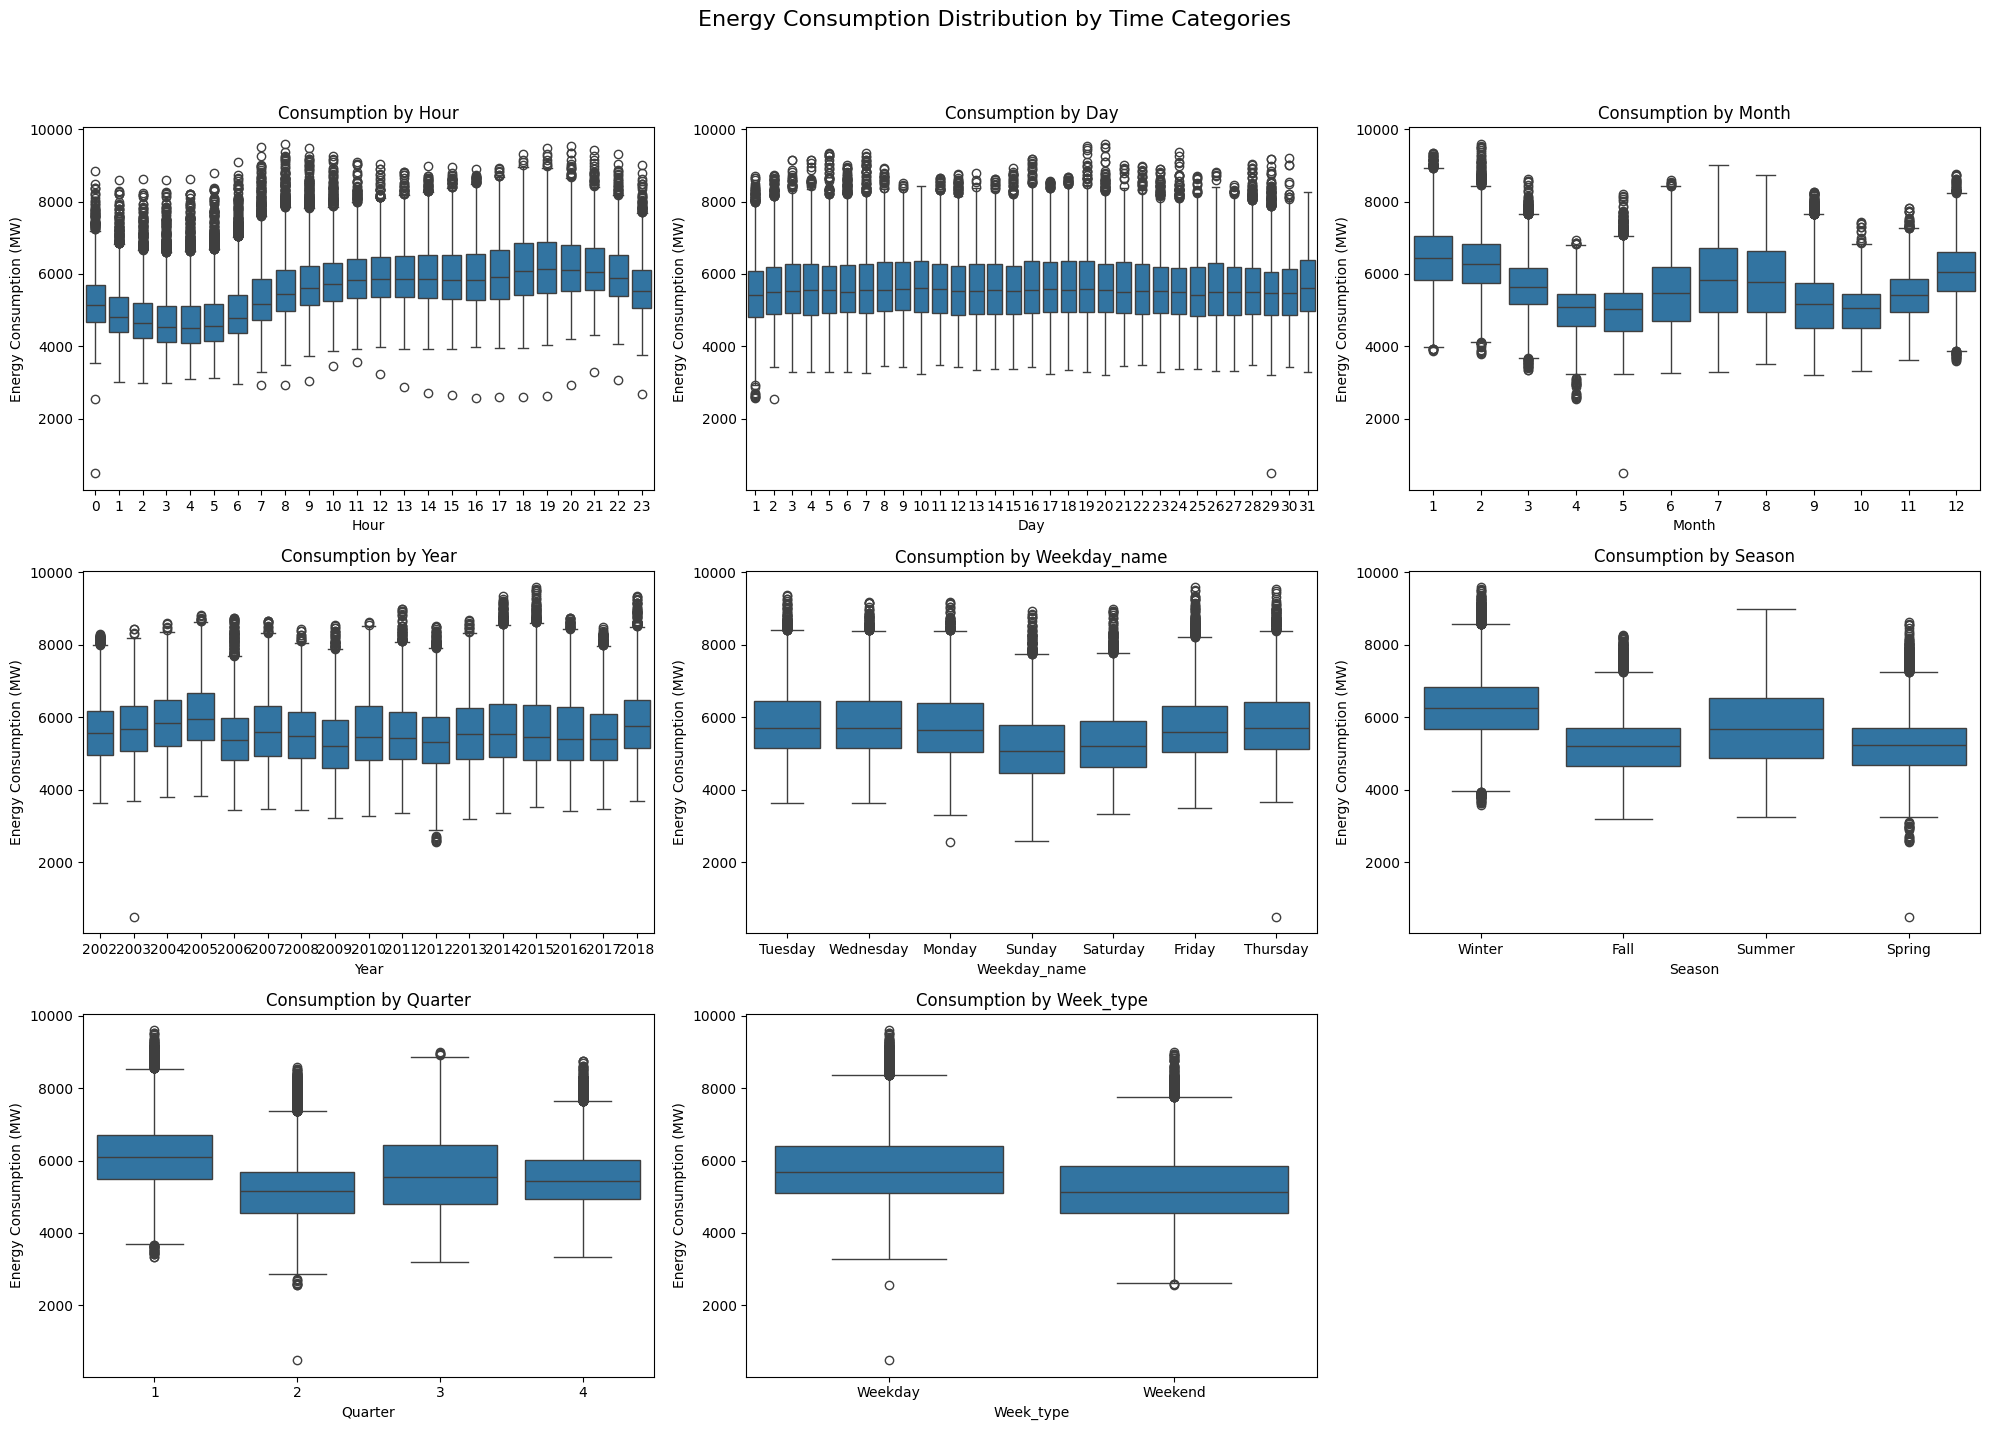

In [6]:
columns = ['hour', 'day', 'month', 'year', 'weekday_name', 'season', 'quarter', 'week_of_year', 'day_of_year', 'week_type']


def is_low_cardinality(column):
    return power_forecasting[column].nunique() < 50

low_cardinality_columns = [col for col in columns if is_low_cardinality(col)]

n_cols = 3
n_rows = (len(low_cardinality_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5 * n_rows))
fig.suptitle('Energy Consumption Distribution by Time Categories', fontsize=16)


for ax, col in zip(axes.flat, low_cardinality_columns):
    sns.boxplot(ax=ax, data=power_forecasting, x=col, y='PJMW_MW')
    ax.set_title(f'Consumption by {col.capitalize()}')
    ax.set_xlabel(col.capitalize())
    ax.set_ylabel('Energy Consumption (MW)')


for i in range(len(low_cardinality_columns), n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Insights
- Median consumption is lowest around 3 AM and highest around 6 PM. There are numerous outliers throughout the day, particularly in the evening
- Median consumption remains relatively stable across the days of the month. There are more outliers towards the end of the month.
- The median consumption is highest in January and December, with more variability and outliers in the summer months
- Median consumption shows a general increase over the years with significant variability. Outliers are more common in the later years
- Median consumption is lowest on Sundays and gradually increases towards Thursdays and Fridays. Outliers are present across all days, with higher values on weekdays
- Winter has the highest median consumption with considerable variability. Summer has the lowest median consumption
- Median consumption is highest in the first quarter and lowest in the third quarter, with notable outliers in each quarter.
- Weekday consumption has a higher median and more variability compared to weekends, which have a lower and more consistent median.


### Conclusions from the EDA
- Energy consumption is lowest during early morning hours and peaks in the evening. This pattern suggests that most energy consumption occurs during active hours when people are awake and businesses are operational, highlighting the typical daily life cycle of the region.
- Energy consumption is higher on weekdays compared to weekends.This indicates that industrial and commercial activities significantly contribute to energy usage, as these sectors are more active during weekdays.
- Energy consumption is highest in winter and lowest in summer. The higher consumption in winter may be due to increased heating requirements, while the lower consumption in summer could reflect less need for heating and possibly more efficient cooling technologies or behavioral changes such as vacation periods.
- There are noticeable fluctuations in annual energy consumption with peaks in certain years. These fluctuations could be influenced by various factors such as economic growth, changes in population, industrial activities, or even weather conditions impacting energy demand.
- There are consistent patterns in energy consumption throughout the year, with certain days experiencing higher usage. Specific days, possibly associated with holidays or significant events, show higher consumption. This pattern can be leveraged for better energy demand forecasting and management during such periods.

### 3. Outliers and Missing values

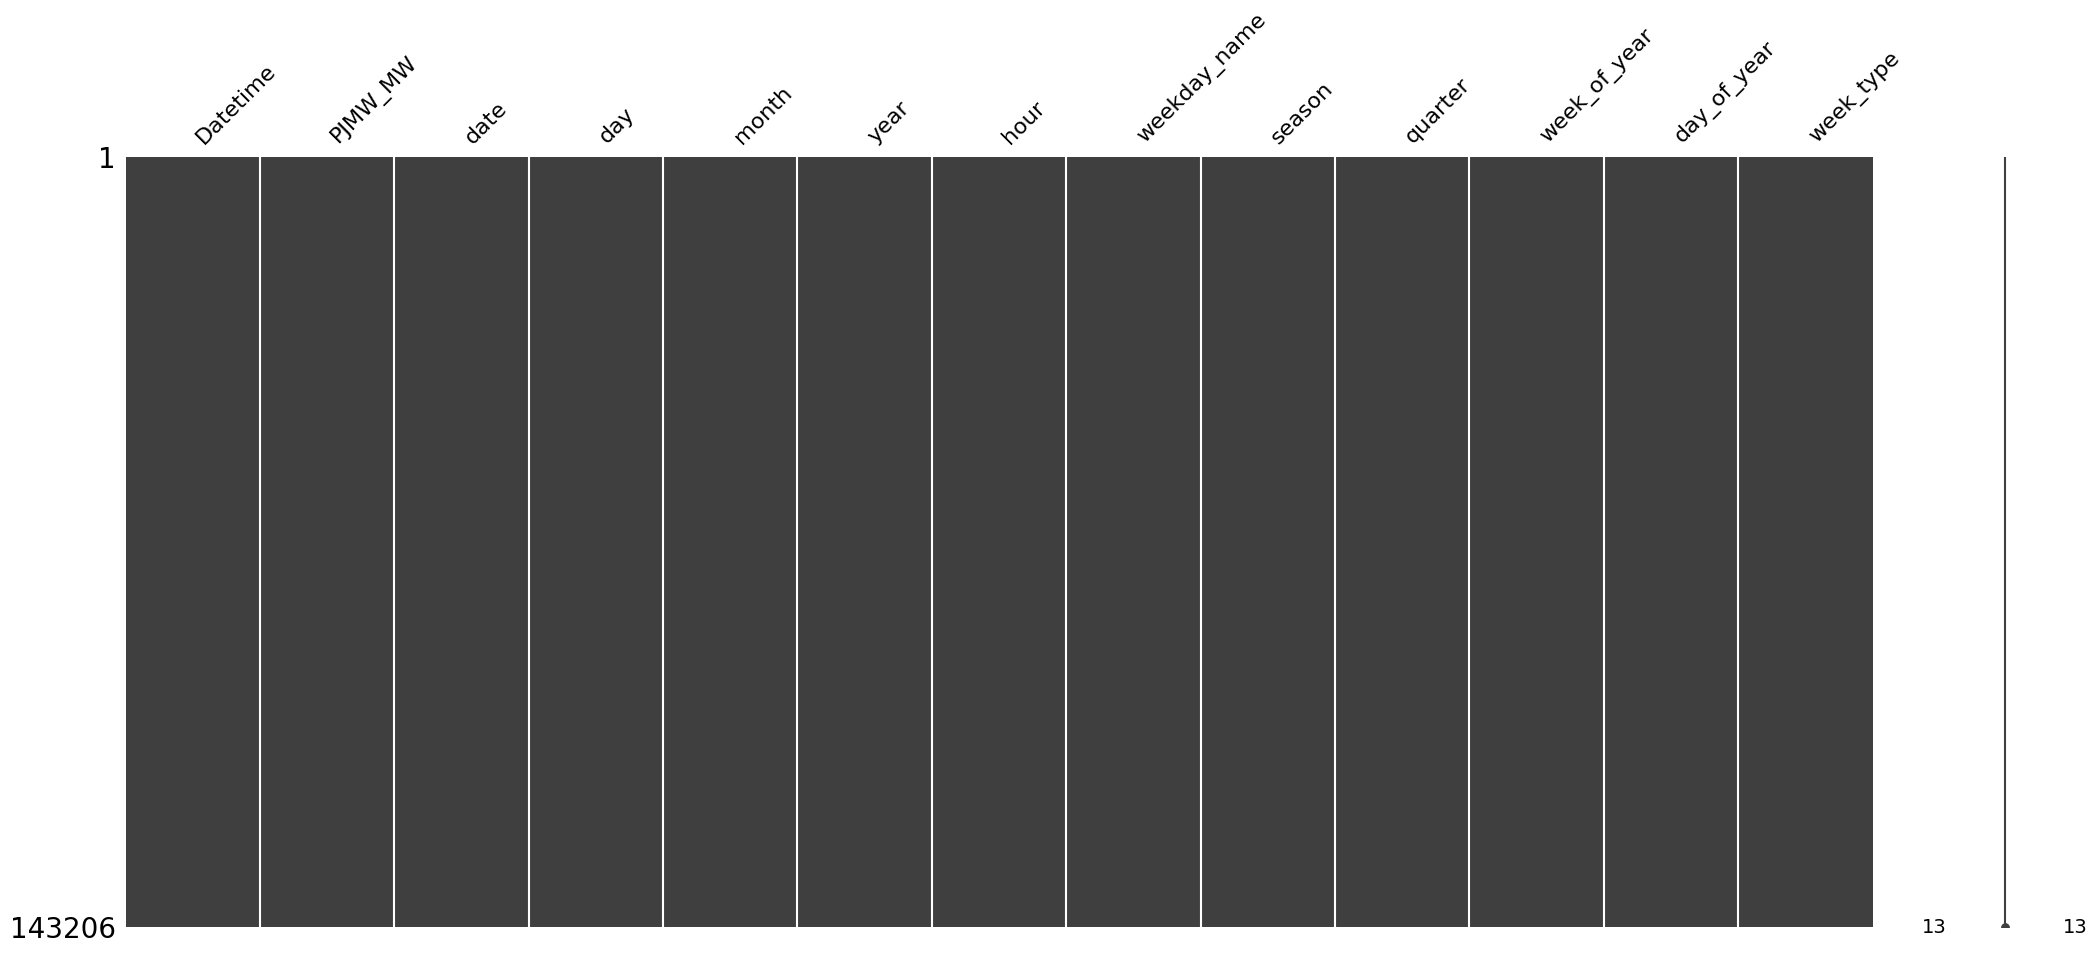

In [7]:
msno.matrix(power_forecasting)
plt.show()

No missing values found in the data

### 4. Autocorrelation and Partial correlation

<Figure size 1200x600 with 0 Axes>

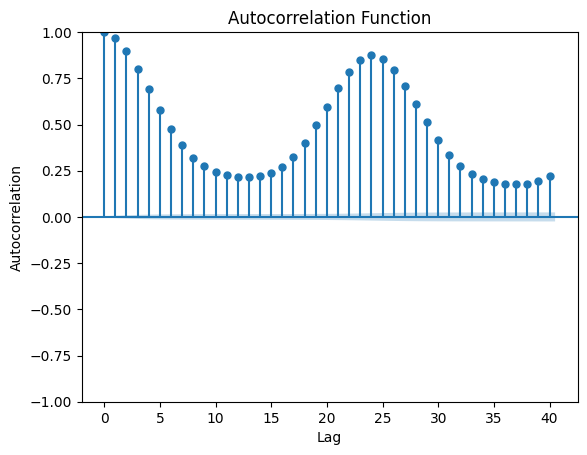

In [8]:
ts=power_forecasting['PJMW_MW']

plt.figure(figsize=(12,6))
plot_acf(ts,lags=40,alpha=0.05)
plt.title('Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

<Figure size 1200x600 with 0 Axes>

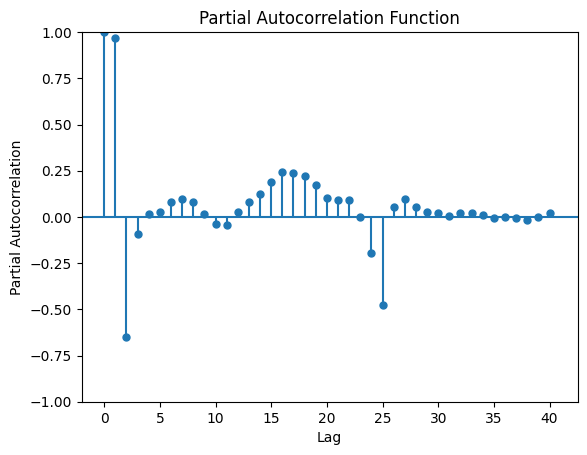

In [9]:
plt.figure(figsize=(12,6))
plot_pacf(ts,lags=40,method='ywm')
plt.title('Partial Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

### 5. Decomposition

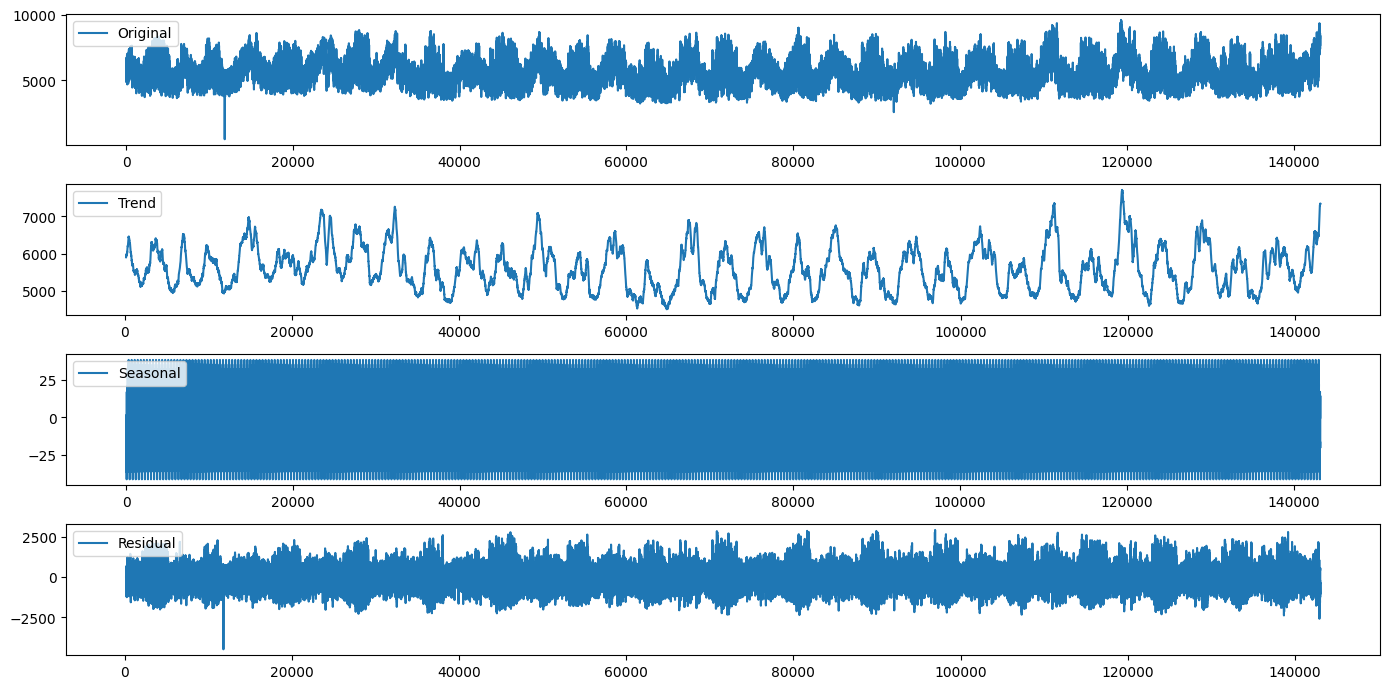

In [10]:
result=seasonal_decompose(power_forecasting['PJMW_MW'],model='additive',period=365)

plt.figure(figsize=(14,7))
plt.subplot(411)
plt.plot(power_forecasting['PJMW_MW'],label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend,label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal,label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid,label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

It appears that there is a noticeable periodic fluctuation, indicating possible seasonal patterns in the energy consumption data and the trend is also centered around the mean

#### Zooming in on Residuals and Seasonal Patterns

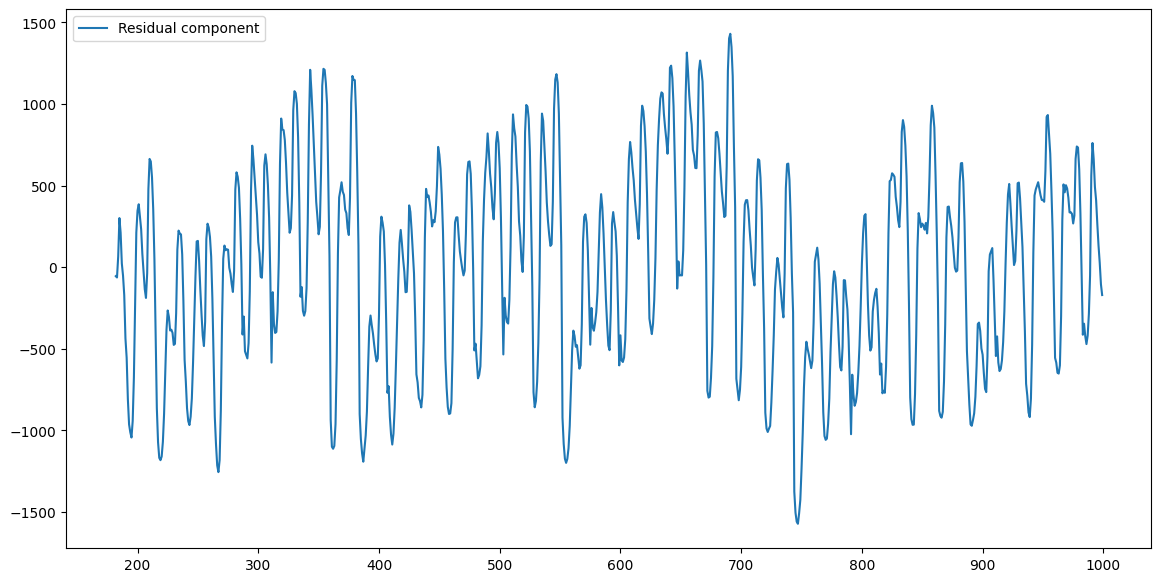

In [11]:
plt.figure(figsize=(14,7))
plt.plot(result.resid[:1000],label='Residual component')
plt.legend(loc='upper left')
plt.show()

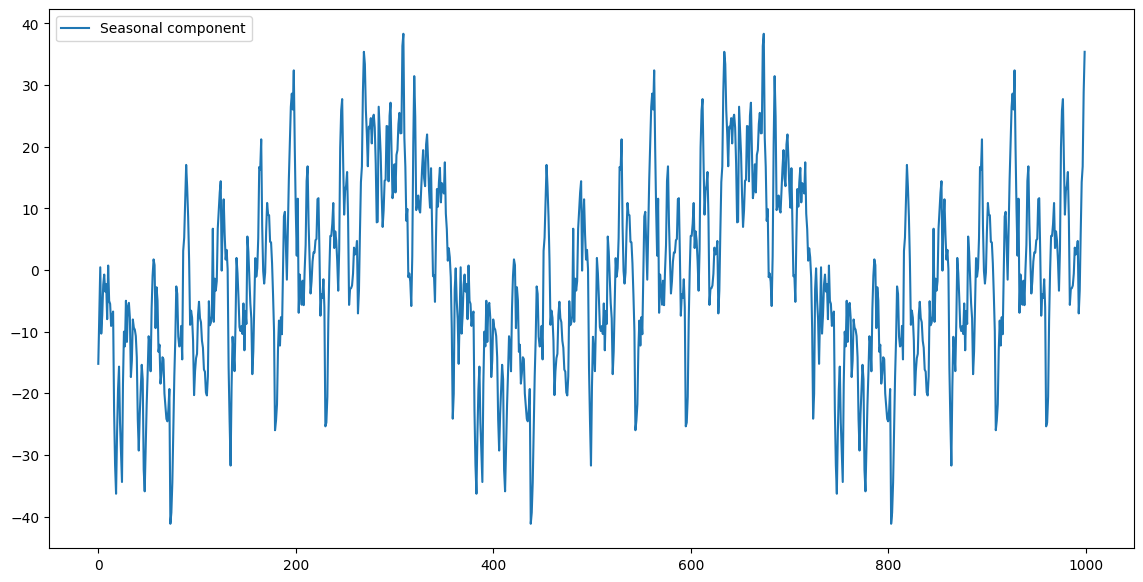

In [12]:
plt.figure(figsize=(14,7))
plt.plot(result.seasonal[:1000],label='Seasonal component')
plt.legend(loc='upper left')
plt.show()

The residual component is completely random which is good since the model has captured the patterns. The seasonal component shows regular peaks and troughs, which indicate repeating patterns in the data.

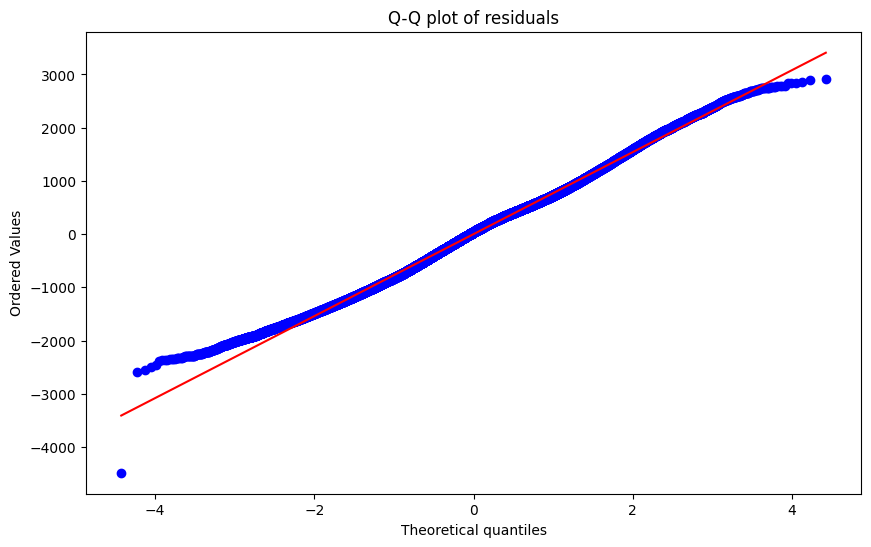

In [13]:
plt.figure(figsize=(10,6))
stats.probplot(result.resid.dropna(),dist="norm",plot=plt)
plt.title('Q-Q plot of residuals')
plt.show()

Residuals that are normally distributed indicate that the model (decomposition) has adequately captured the structure in the data, leaving only random noise. This suggests that the trend and seasonal components have been accurately identified and removed.

### 6. Rolling Statistics

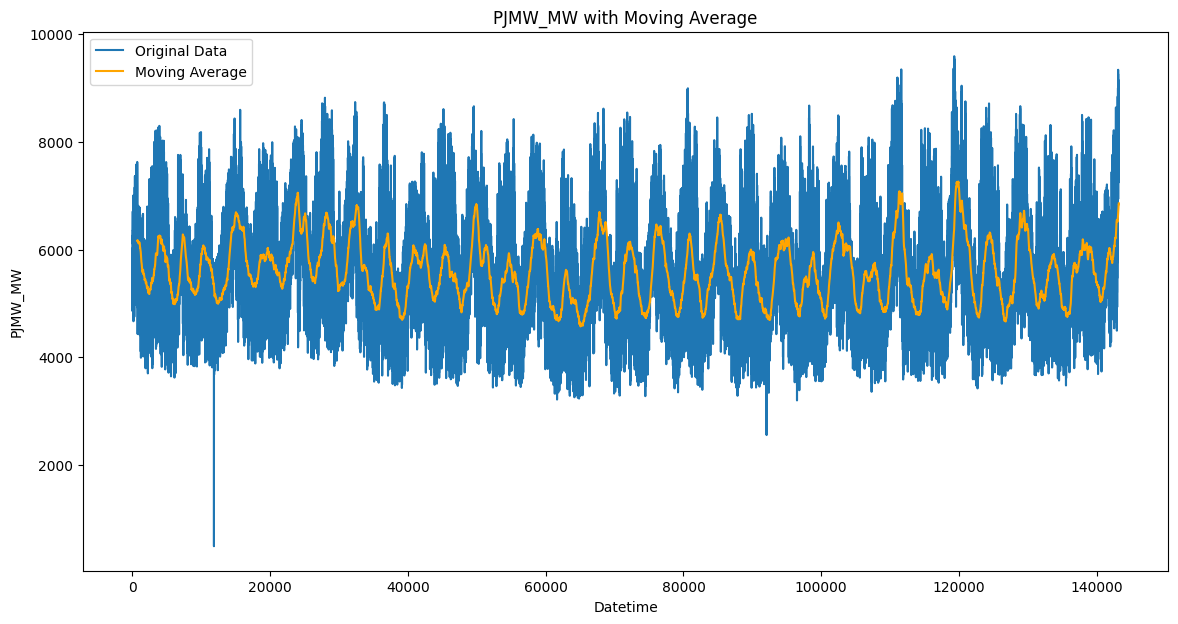

In [14]:
window_size =720
power_forecasting['Moving_Avg']=power_forecasting['PJMW_MW'].rolling(window=window_size).mean()

plt.figure(figsize=(14,7))
plt.plot(power_forecasting['PJMW_MW'],label='Original Data')
plt.plot(power_forecasting['Moving_Avg'],label='Moving Average',color='orange')
plt.title('PJMW_MW with Moving Average')
plt.xlabel('Datetime')
plt.ylabel('PJMW_MW')
plt.legend()
plt.show()

### 7. Checking for stationarity

In [15]:
adf_test=adfuller(result.resid.dropna())
print(f'ADF statistic : {adf_test[0]}')
print(f'p-value : {adf_test[1]}')
for key,value in adf_test[4].items():
    print(f'Critical value {key}: {value}')

ADF statistic : -49.619503776035884
p-value : 0.0
Critical value 1%: -3.4303958048259053
Critical value 5%: -2.861560245082258
Critical value 10%: -2.566780775737218


The null hypothesis (H0) of the ADF test is that the time series has a unit root, meaning it is non-stationary. Given that the ADF statistic (-49.6195) is much lower (more negative) than any of the critical values at the 1%, 5%, and 10% levels, you can reject the null hypothesis.

### 8. Forecast vs Actuals with prophet and XGBoost model

In [16]:
forecasting_model = pd.read_csv('PJMW_hourly.csv')
forecasting_model['Datetime']=pd.to_datetime(forecasting_model['Datetime'])
forecasting_model.sort_values(by='Datetime',inplace=True)
forecasting_model.set_index('Datetime',inplace=True)

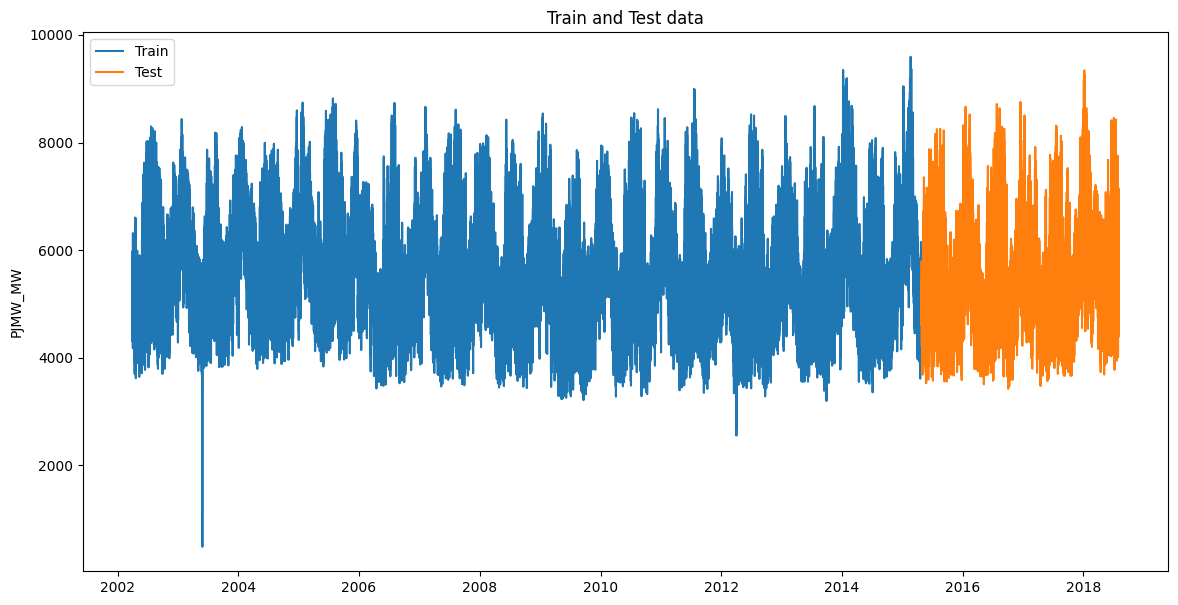

In [17]:
train_size=int(len(forecasting_model)*0.8)
train, test= forecasting_model[:train_size],forecasting_model[train_size:]

plt.figure(figsize=(14,7))
plt.plot(train['PJMW_MW'],label='Train')
plt.plot(test['PJMW_MW'],label='Test')
plt.legend()
plt.title('Train and Test data')
plt.ylabel('PJMW_MW')
plt.show()

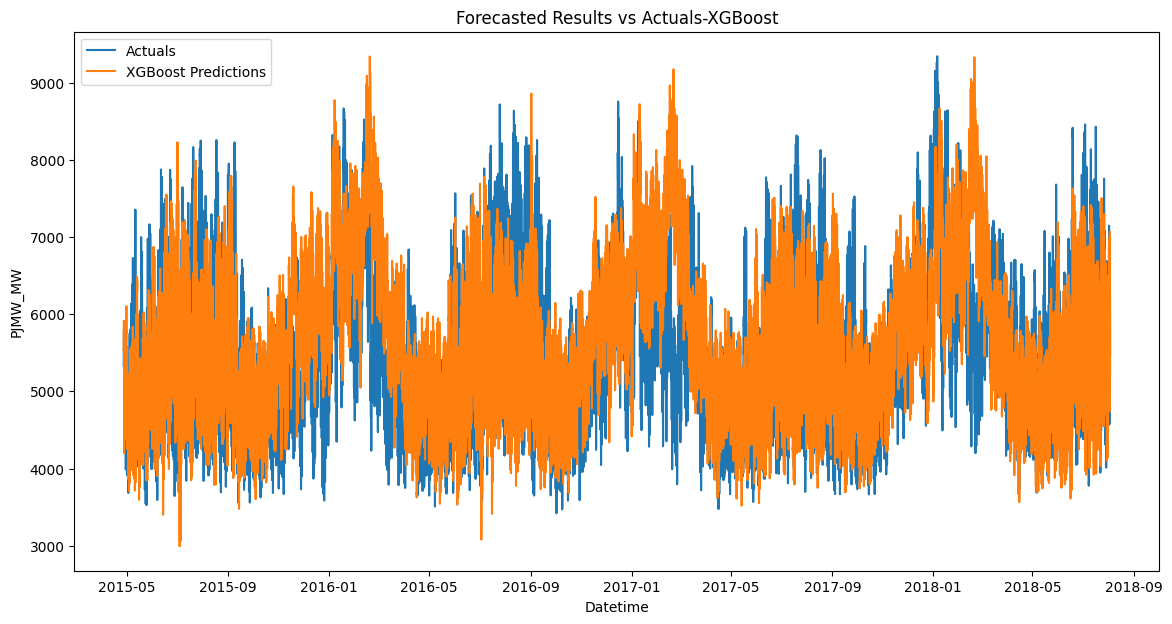

13:28:59 - cmdstanpy - INFO - Chain [1] start processing
13:29:52 - cmdstanpy - INFO - Chain [1] done processing


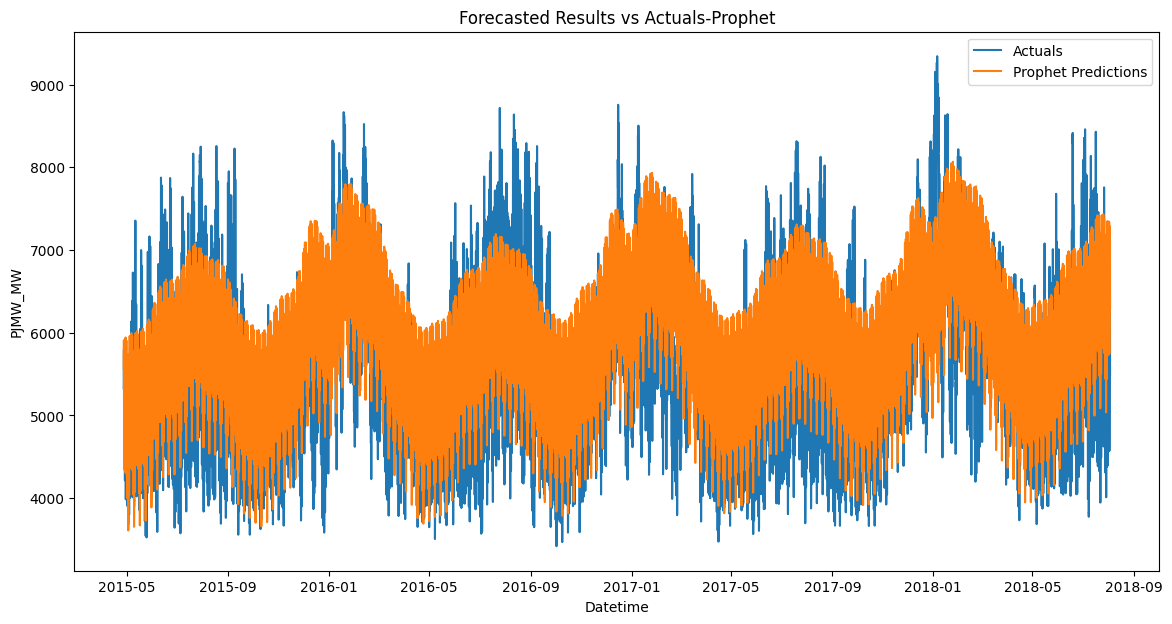

In [18]:
def create_features(df,label=None):
    df['hour']=df.index.hour
    df['dayofweek']=df.index.dayofweek
    df['quarter']=df.index.quarter
    df['month']=df.index.month
    df['year']=df.index.year
    df['dayofyear']=df.index.dayofyear
    df['dayofmonth']=df.index.day
    df['weekofyear']=df.index.isocalendar().week
    X=df[['hour','dayofweek','month','quarter','year','dayofyear','dayofmonth','weekofyear']]
    if label:
        y=df[label]
        return X,y
    return X 

X_train, y_train=create_features(train,label='PJMW_MW')
X_test, y_test=create_features(test,label='PJMW_MW')

model=XGBRegressor(objective='reg:squarederror',n_estimators=1000)
model.fit(X_train,y_train)
xgb_preds=model.predict(X_test)


plt.figure(figsize=(14,7))
plt.plot(test.index,test['PJMW_MW'],label='Actuals')
plt.plot(test.index,xgb_preds,label='XGBoost Predictions')
plt.title('Forecasted Results vs Actuals-XGBoost')
plt.legend()
plt.xlabel('Datetime')
plt.ylabel('PJMW_MW')
plt.show()


prophet_df=forecasting_model.reset_index().rename(columns={'Datetime':'ds','PJMW_MW':'y'})
prophet_train=prophet_df[:train_size]
prophet_test=prophet_df[train_size:]

prophet_model=Prophet()
prophet_model.fit(prophet_train)
future=prophet_model.make_future_dataframe(periods=len(prophet_test),freq='H')
forecast=prophet_model.predict(future)
prophet_preds=forecast[['ds','yhat']].set_index('ds').loc[test.index]

plt.figure(figsize=(14,7))
plt.plot(test.index,test['PJMW_MW'],label='Actuals')
plt.plot(test.index,prophet_preds['yhat'],label='Prophet Predictions')
plt.title('Forecasted Results vs Actuals-Prophet')
plt.legend()
plt.xlabel('Datetime')
plt.ylabel('PJMW_MW')
plt.show()


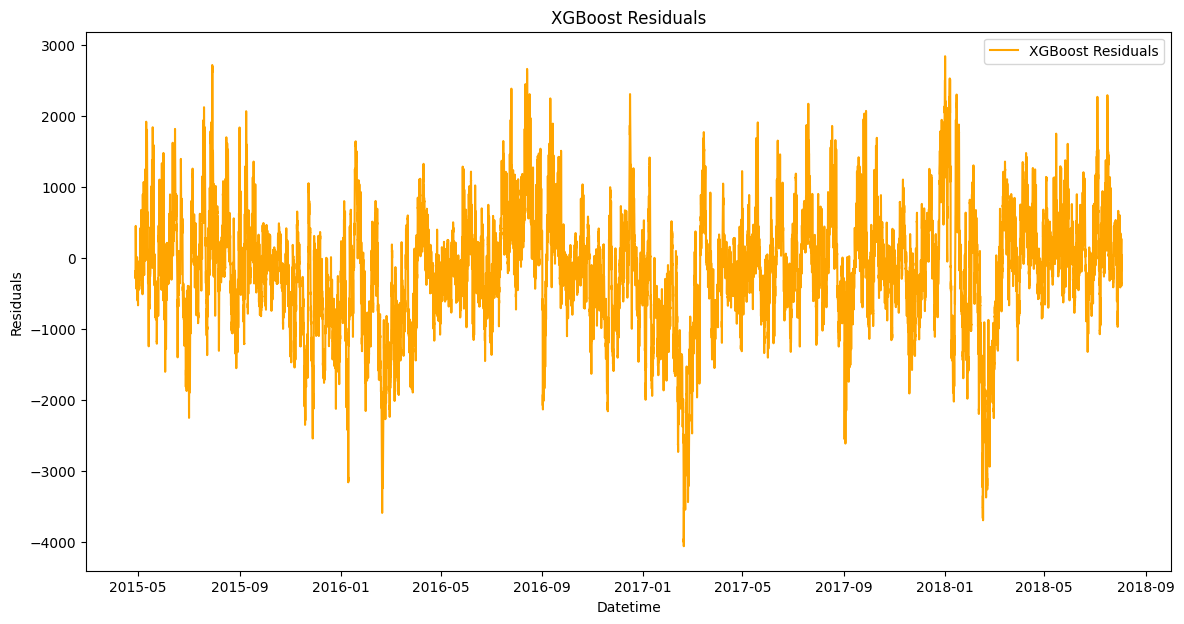

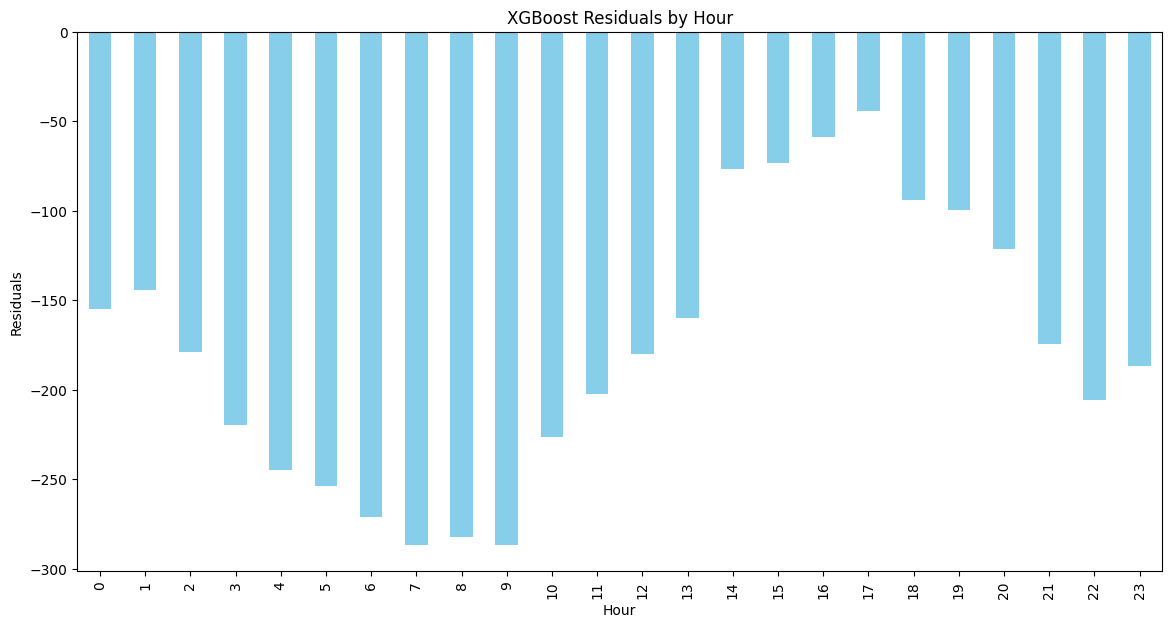

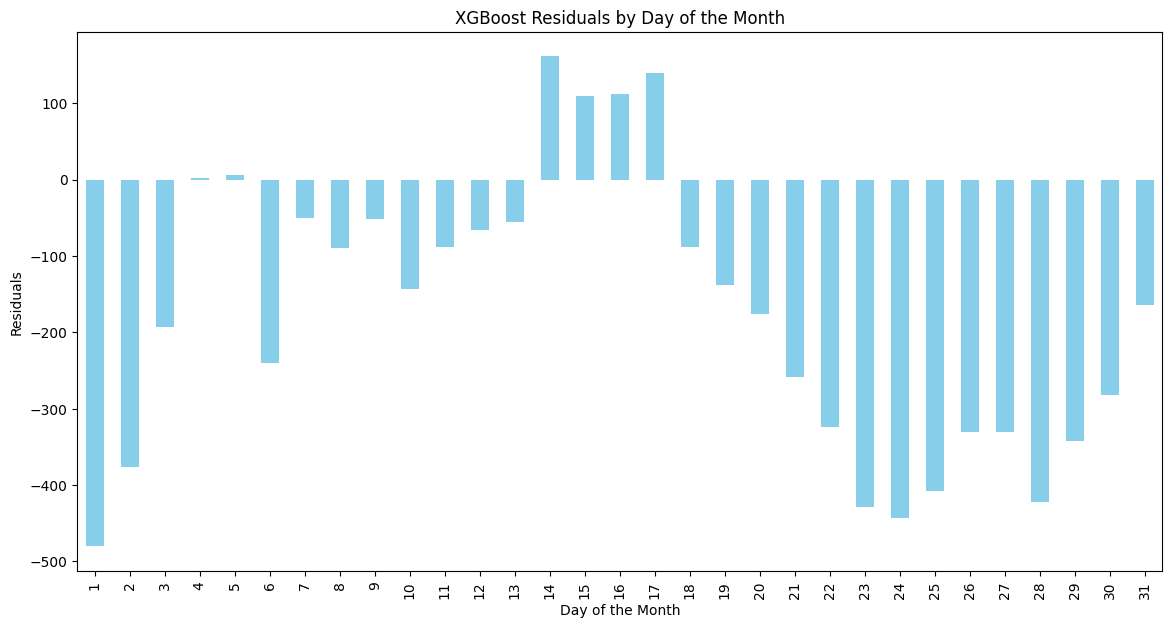

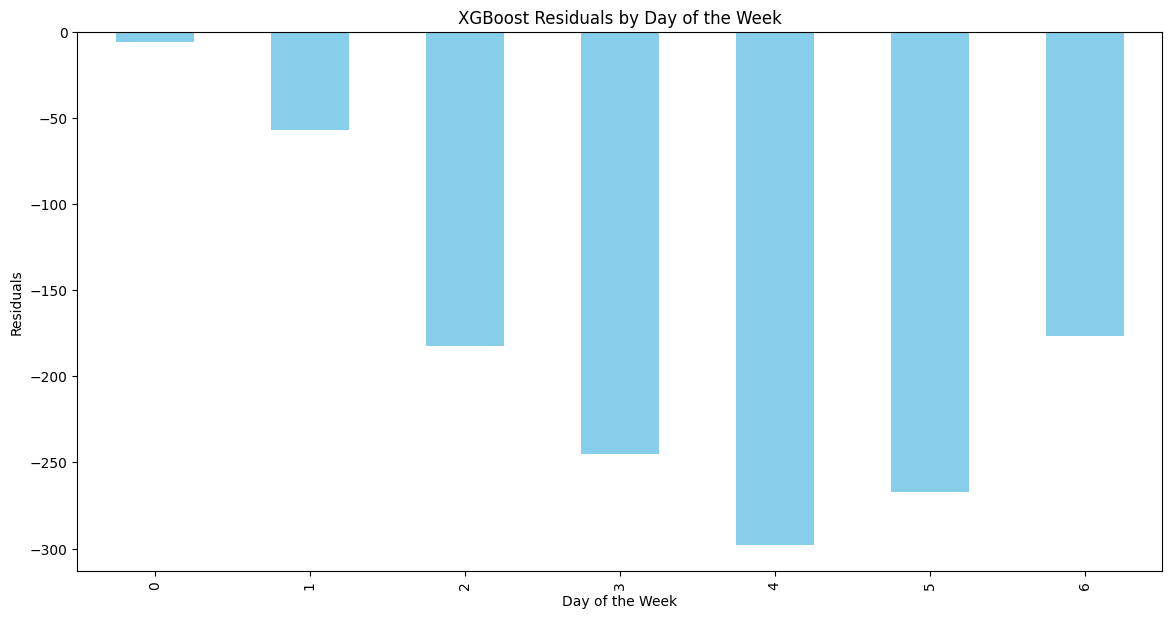

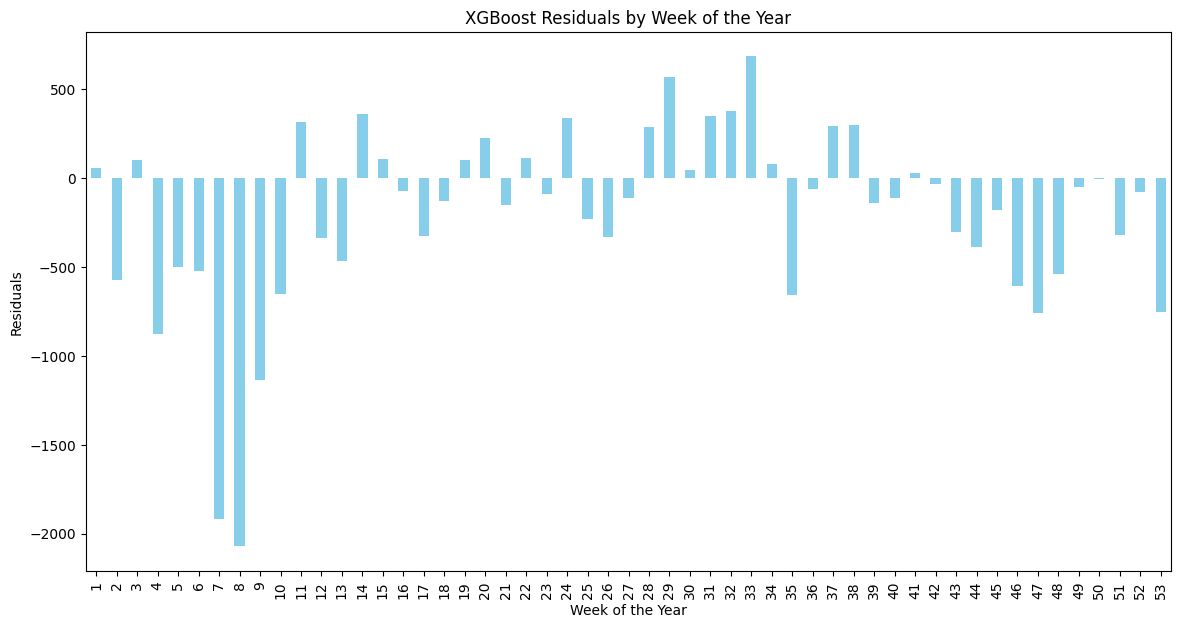

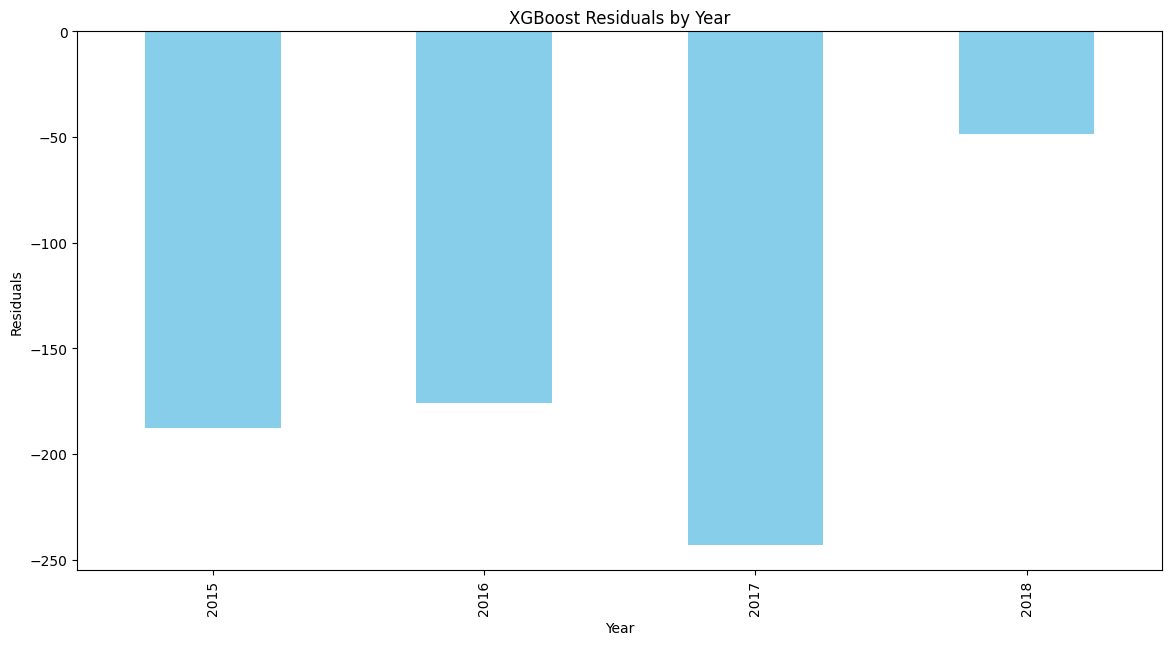

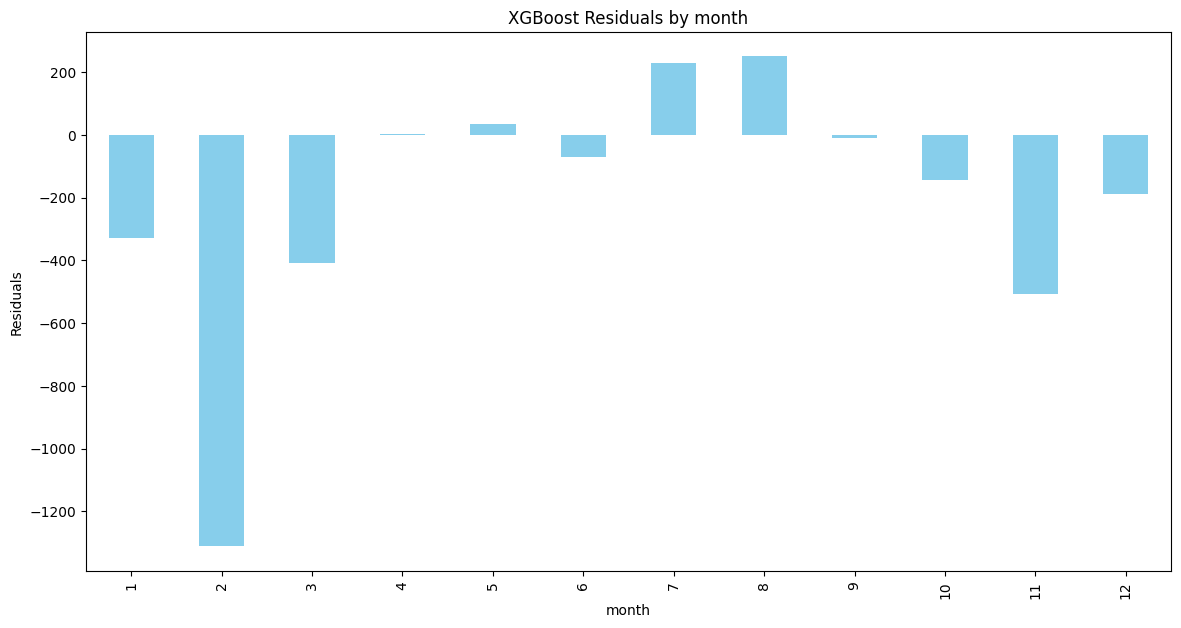

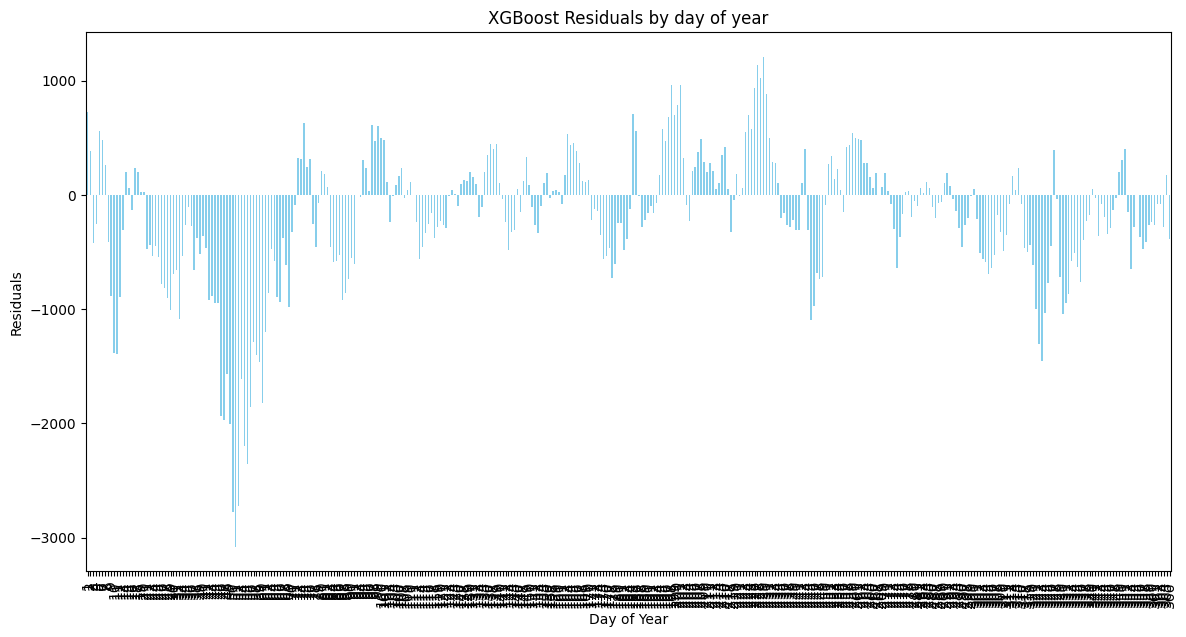

In [19]:
def plot_residuals(df, feature, title, xlabel, ylabel):
    residuals = df.groupby(feature)['residuals'].mean()
    plt.figure(figsize=(14, 7))
    residuals.plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

xgb_residuals = y_test - xgb_preds
features = create_features(test)
features['residuals'] = xgb_residuals

plt.figure(figsize=(14, 7))
plt.plot(test.index, xgb_residuals, label='XGBoost Residuals', color='orange')
plt.title('XGBoost Residuals')
plt.xlabel('Datetime')
plt.ylabel('Residuals')
plt.legend()
plt.show()


plot_residuals(features, 'hour', 'XGBoost Residuals by Hour', 'Hour', 'Residuals')
plot_residuals(features, 'dayofmonth', 'XGBoost Residuals by Day of the Month', 'Day of the Month', 'Residuals')
plot_residuals(features, 'dayofweek', 'XGBoost Residuals by Day of the Week', 'Day of the Week', 'Residuals')
plot_residuals(features, 'weekofyear', 'XGBoost Residuals by Week of the Year', 'Week of the Year', 'Residuals')
plot_residuals(features, 'year', 'XGBoost Residuals by Year', 'Year', 'Residuals')
plot_residuals(features, 'month', 'XGBoost Residuals by month', 'month', 'Residuals')
plot_residuals(features, 'dayofyear', 'XGBoost Residuals by day of year', 'Day of Year', 'Residuals')


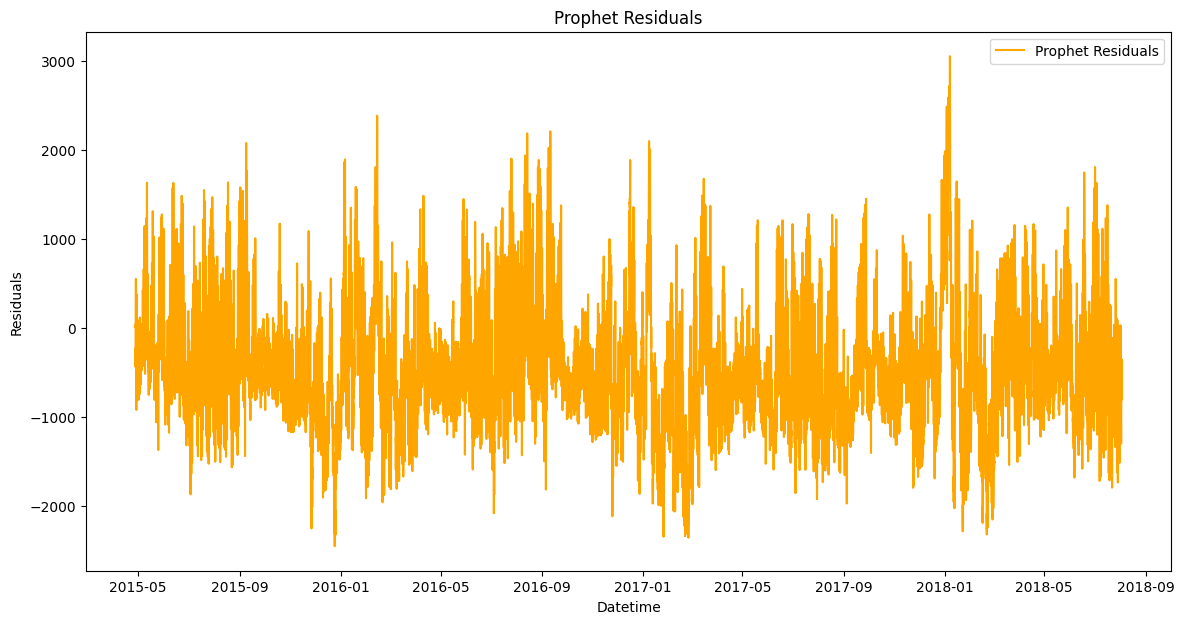

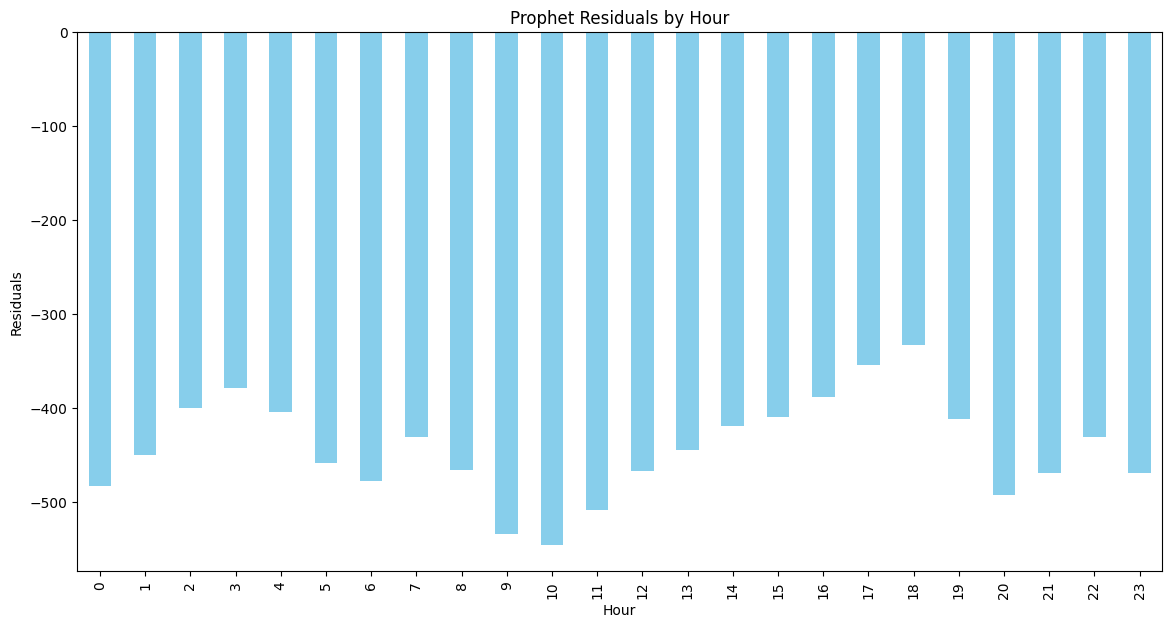

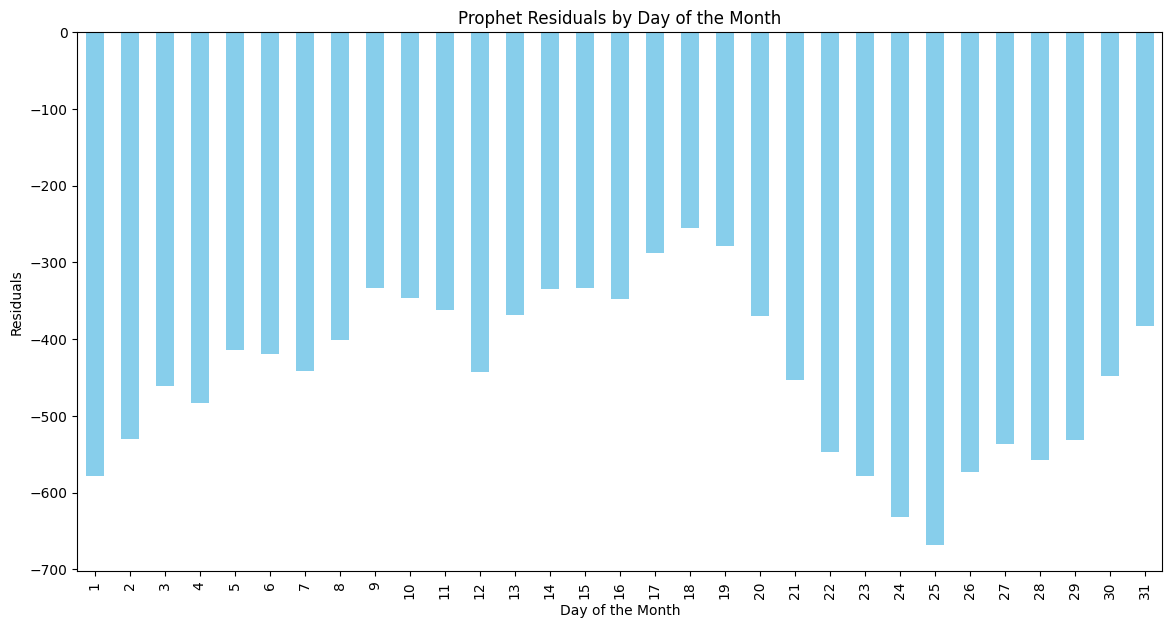

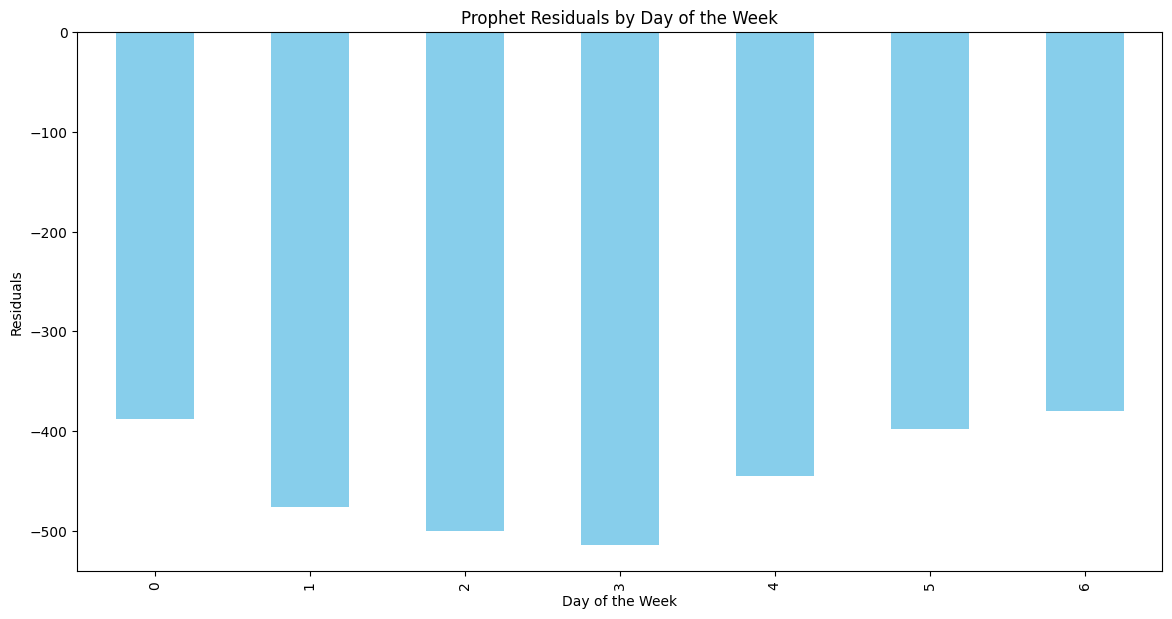

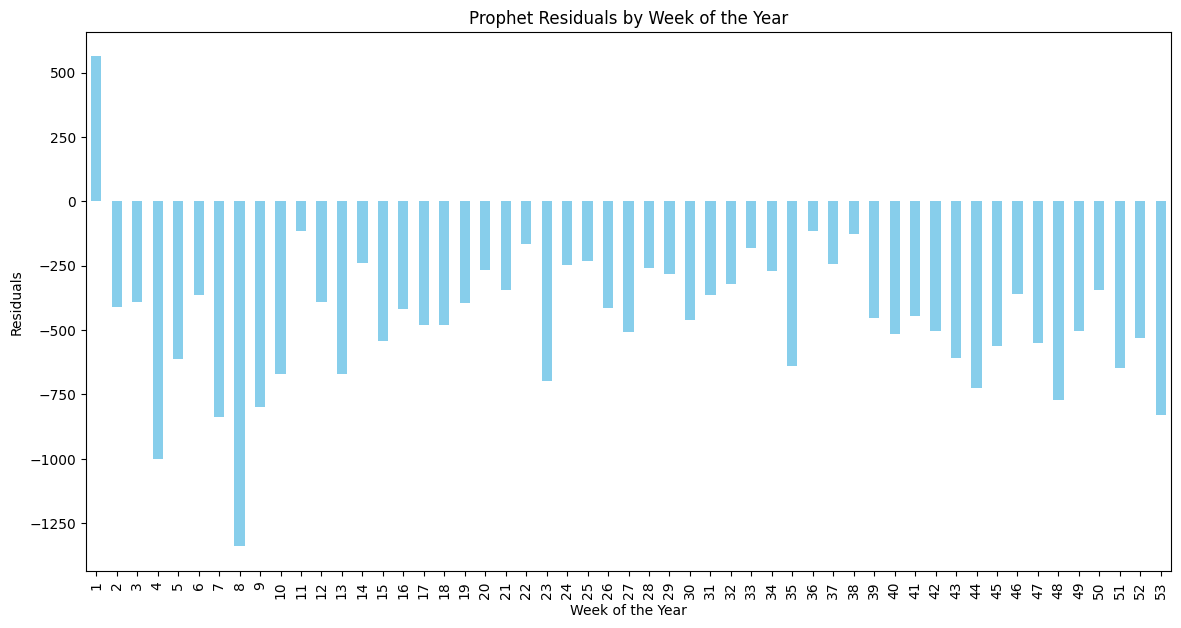

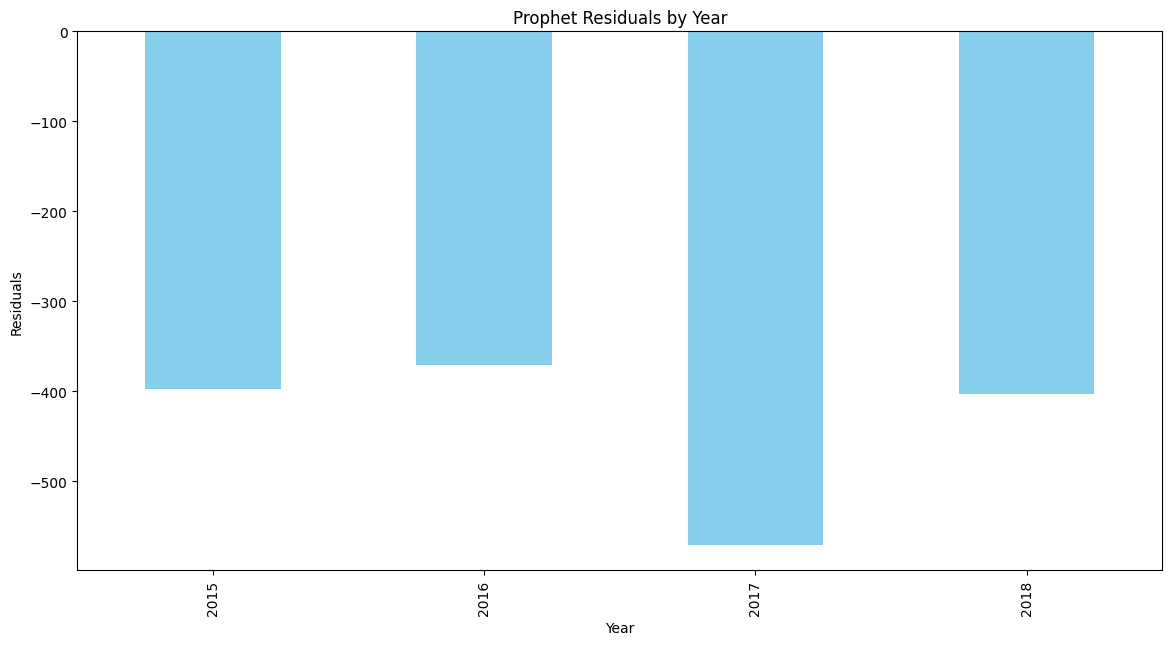

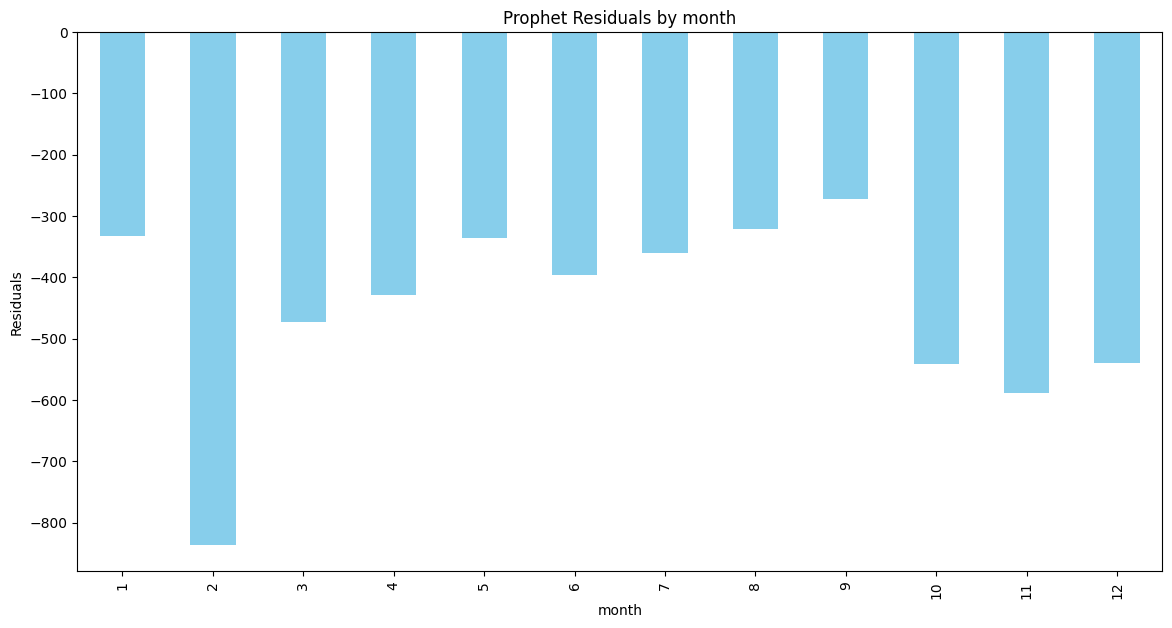

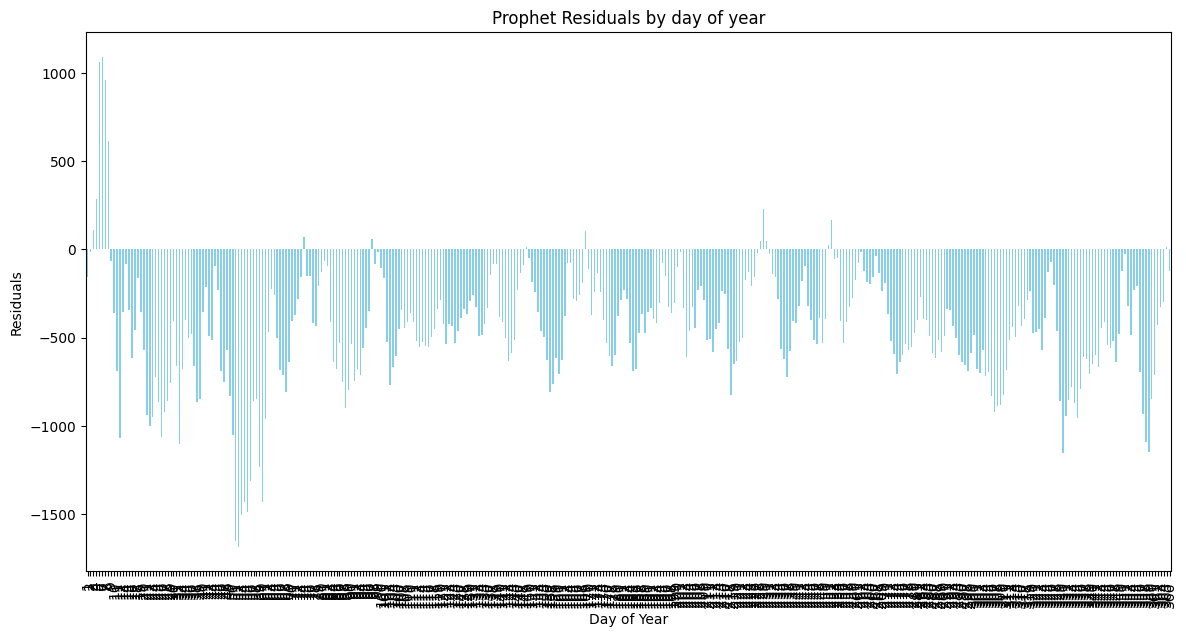

In [20]:
prophet_residuals = test['PJMW_MW'] - prophet_preds['yhat']
features = create_features(test)
features['residuals'] = prophet_residuals

plt.figure(figsize=(14, 7))
plt.plot(test.index, prophet_residuals, label='Prophet Residuals', color='orange')
plt.title('Prophet Residuals')
plt.xlabel('Datetime')
plt.ylabel('Residuals')
plt.legend()
plt.show()


plot_residuals(features, 'hour', 'Prophet Residuals by Hour', 'Hour', 'Residuals')
plot_residuals(features, 'dayofmonth', 'Prophet Residuals by Day of the Month', 'Day of the Month', 'Residuals')
plot_residuals(features, 'dayofweek', 'Prophet Residuals by Day of the Week', 'Day of the Week', 'Residuals')
plot_residuals(features, 'weekofyear', 'Prophet Residuals by Week of the Year', 'Week of the Year', 'Residuals')
plot_residuals(features, 'year', 'Prophet Residuals by Year', 'Year', 'Residuals')
plot_residuals(features, 'month', 'Prophet Residuals by month', 'month', 'Residuals')
plot_residuals(features, 'dayofyear', 'Prophet Residuals by day of year', 'Day of Year', 'Residuals')


- Both XGBoost and Prophet has higher residuals during the initial time period of the year. 
- XGBoost has positive and negative residuals- meaning that we are overestimating and underestimating some periods
- The overall residuals across all time periods for both the models are centered around the mean and doesn't show higher deviations across.